# Manifold Activation Patching

This notebook is an end-to-end, controlled intervention study for percentage-to-fraction behavior.

It covers four phases:
1. Generate a synthetic dataset of percentage prompts.
2. Capture per-sequence hidden activations at a fixed middle layer.
3. Establish baseline generation quality with quantitative diagnostics.
4. Run donor-based activation patching and compare post-patch behavior to baseline.

The design goal is causal probing: change one internal representation at a specific token and measure whether output behavior shifts in the expected direction.


## Hypothesis

Core hypothesis:
- Percentage semantics are encoded in local hidden-state features at/near the `%` token.
- If we replace that local feature with one from another sample, generation should move toward the donor sample's fraction behavior.

Operational hypothesis for this notebook:
- Source sequence = prompt being generated.
- Donor sequence = different test-set sequence providing the patch vector.
- Successful steering should reduce error relative to donor targets and increase donor-aligned confusion-matrix mass.

This experiment intentionally keeps intervention simple (single-token patch at one layer) to maximize interpretability of outcomes.


In [1]:
from __future__ import annotations

import json
import re
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import plotly.graph_objects as go
import torch
import tqdm
from nnsight import LanguageModel
from sklearn.model_selection import train_test_split


## Configuration

This block defines reproducible runtime settings and data schema constants.

Key choices:
- `SEED`: fixes sampling and donor selection.
- `N_PROMPTS`: controls dataset size and runtime.
- `M_NEW_TOKENS`: limits output span to short fraction-like completions.
- `INSTRUCTION_PREFIX`: constrains outputs to known fraction labels.
- `FRACTION_MAP`: maps linguistic fraction classes to percentage ranges for sampling and evaluation.

The output directory naming is deterministic so generated artifacts can be reused across reruns.


In [2]:
FRACTION_MAP = {
    "one half": {"range_percent": [45, 55]},
    "two thirds": {"range_percent": [62, 72]},
    "three quarters": {"range_percent": [70, 80]},
    "one third": {"range_percent": [28, 38]},
    "one quarter": {"range_percent": [22, 28]},
    "one fifth": {"range_percent": [17, 23]},
    "one sixth": {"range_percent": [14, 19]},
    "one seventh": {"range_percent": [12, 16]},
    "one eighth": {"range_percent": [10, 14]},
    "one ninth": {"range_percent": [9, 13]},
    "one tenth": {"range_percent": [8, 12]},
}

SEED = 123
N_PROMPTS = 1000
M_NEW_TOKENS = 3
MODEL_ID = "meta-llama/Llama-3.1-8B-Instruct"
DEVICE = "mps"
INSTRUCTION_PREFIX = f"Respond with exactly one of: [{', '.join(FRACTION_MAP.keys())}]."

DATA_ROOT = Path("activations")
MODEL_SLUG = MODEL_ID.replace("/", "_")
OUT_DIR = DATA_ROOT / f"pct_token_activations_{MODEL_SLUG}_n{N_PROMPTS}"
META_PATH = OUT_DIR / "metadata.jsonl"


## Helpers

Helper utilities serve three purposes:
1. **Data generation** (`sample_p1`, `build_prompt`) for controlled prompt distribution.
2. **Model access** (`resolve_residual_layers`) to support architecture variants.
3. **Evaluation mapping** (`fraction_text_to_mathched_text`, `fraction_text_to_percent`) to convert free text into class/percent signals.

Important evaluation note:
- The text-to-fraction matcher is intentionally permissive to tolerate tokenization artifacts and short completions.
- This can increase mapped coverage but may over-credit ambiguous generations.


In [3]:
@dataclass(frozen=True)
class Prompt:
    text: str
    p_1: int
    frac_1: str


def sample_p1(rng: np.random.Generator, frac: str) -> int:
    r_min, r_max = FRACTION_MAP[frac]["range_percent"]
    mean = (r_min + r_max) / 2
    sigma = (r_max - r_min) / 4
    p_1 = int(round(rng.normal(loc=mean, scale=sigma)))
    return max(r_min, min(r_max, p_1))


def build_prompt(p_1: int) -> str:
    return f"{p_1}% is"


def resolve_residual_layers(model: LanguageModel):
    if hasattr(model, "transformer") and hasattr(model.transformer, "h"):
        return model.transformer.h
    if hasattr(model, "model") and hasattr(model.model, "layers"):
        return model.model.layers
    raise ValueError("Unsupported model structure for residual stream access.")


def fraction_text_to_mathched_text(text: str) -> str | None:
    text = text.lower()
    words = re.findall(r"[a-zA-Z]+", text)
    if not words:
        return None
    for fraction, _spec in FRACTION_MAP.items():
        target_words = [w.lower() for w in fraction.split()]
        if all(list(word.lower() in target_words for word in words)[:2]):
            return fraction
    return None


def fraction_text_to_percent(text: str) -> int | None:
    if text is not None:
        matched = fraction_text_to_mathched_text(text)
        r_min, r_max = FRACTION_MAP[matched]["range_percent"]
        return int(round((r_min + r_max) / 2))
    return None


## Dataset Format and Token Regions Used

### Saved artifacts
- `activations/.../{seq_id}.npy`
  - shape: `[n_prompt_tokens, d_model]`
  - content: middle-layer hidden states for the full prompt sequence.
- `activations/.../metadata.jsonl`
  - one JSON record per sequence with prompt, token, and decoding metadata.

### Metadata schema
Each row includes:
- Identity: `seq_id`
- Prompt tokenization: `token_ids`, `decoded_tokens`
- Localized anchor: `pct_token_index` (first token containing `%`)
- Generation output: `decoded_sequence`
- Ground truth: `target_frac`, `target_pct`
- Parsed output: `decoded_frac`, `decoded_pct`, `matched`

### Token-level intervention focus
- Capture phase: stores activations for all prompt tokens.
- Analysis phase: computes quality on generated continuation tokens.
- Patch phase: edits one hidden vector at `pct_token_index` and then generates continuation tokens.


## Generate Prompts and Initialize Model

This stage creates the controlled experiment population:
- Sample fraction classes from `FRACTION_MAP`.
- Sample percentages within each class-specific range.
- Build prompts in the form `"{p}% is"`.

It also initializes the model and resolves:
- which transformer layer list to use,
- the middle-layer index for capture/patch,
- the runtime device for tensors and generation.


In [4]:
model = LanguageModel(MODEL_ID, device_map=DEVICE, dtype=torch.float32, dispatch=True)
rng = np.random.default_rng(SEED)

fractions = list(FRACTION_MAP.keys())
prompts: list[Prompt] = []
for _ in range(N_PROMPTS):
    frac = rng.choice(fractions)
    p_1 = sample_p1(rng, frac)
    prompts.append(Prompt(text=build_prompt(p_1), p_1=p_1, frac_1=frac))

layers = resolve_residual_layers(model)
mid_layer = len(layers) // 2
hf_model = getattr(model, "_model", model)

device = None
if hasattr(hf_model, "parameters"):
    for param in hf_model.parameters():
        device = param.device
        break

OUT_DIR.mkdir(parents=True, exist_ok=True)


Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

## Collect Activations and Metadata

For each sequence:
1. Build chat-formatted prompt.
2. Tokenize and locate `%` token index.
3. Trace middle-layer hidden states for the full prompt.
4. Save one activation array to disk.
5. Generate continuation tokens and parse decoded output.
6. Append one metadata JSONL row.

Memory strategy:
- Activations are saved **per sequence** (`1 .npy per prompt`) so the run does not accumulate all hidden states in memory, preventing OOM on larger `N_PROMPTS`.


In [5]:
outputs = []

with META_PATH.open("w", encoding="utf-8") as meta_handle:
    for seq_id, prompt in tqdm.contrib.tenumerate(prompts):
        prompt_template = [
            {"role": "system", "content": INSTRUCTION_PREFIX},
            {"role": "user", "content": prompt.text},
            {"role": "assistant", "content": "Answer:"},
        ]
        chat_prompt = model.tokenizer.apply_chat_template(
            prompt_template, continue_final_message=True, tokenize=False
        )

        tokenized = model.tokenizer(chat_prompt, return_tensors="pt")
        input_ids = tokenized["input_ids"]
        attention_mask = tokenized.get("attention_mask")
        if device is not None:
            input_ids = input_ids.to(device)
            if attention_mask is not None:
                attention_mask = attention_mask.to(device)

        token_ids = input_ids[0].tolist()
        decoded_tokens = [model.tokenizer.decode(idx) for idx in token_ids]
        pct_indices = [i for i, tok in enumerate(decoded_tokens) if "%" in tok]
        if not pct_indices:
            raise ValueError("Could not find '%' token in chat prompt.")
        pct_token_index = pct_indices[0]

        with model.trace(input_ids):
            resid = layers[mid_layer].output[0, :, :].save()

        np.save(OUT_DIR / f"{seq_id}.npy", resid.detach().cpu().numpy())

        generated = hf_model.generate(
            input_ids,
            attention_mask=attention_mask,
            max_new_tokens=M_NEW_TOKENS,
            do_sample=False,
            pad_token_id=model.tokenizer.eos_token_id,
        )
        new_ids = generated[0].tolist()[input_ids.shape[1]:]
        decoded = model.tokenizer.decode(new_ids)
        outputs.append((prompt, decoded))

        decoded_text = fraction_text_to_mathched_text(decoded)
        decoded_pct = fraction_text_to_percent(decoded_text)
        matched = decoded_pct is not None

        meta_handle.write(
            json.dumps(
                {
                    "seq_id": seq_id,
                    "token_ids": token_ids,
                    "pct_token_index": pct_token_index,
                    "decoded_tokens": decoded_tokens,
                    "decoded_sequence": decoded,
                    "target_frac": prompt.frac_1,
                    "target_pct": prompt.p_1,
                    "decoded_frac": decoded_text,
                    "decoded_pct": decoded_pct,
                    "matched": matched,
                }
            )
            + "\n"
        )


  0%|          | 0/1000 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
You have set `compile_config`, but we are unable to meet the criteria for compilation. Compilation will be skipped.


## Baseline Decoding Metric

Baseline quantifies model behavior before any intervention.

Reported metrics:
- `MSE(decoded_pct, target_pct)` over mapped outputs.
- `unmapped rate` for completions that cannot be parsed into known fraction classes.

Interpretation:
- Lower MSE indicates better numeric alignment.
- Lower unmapped rate indicates better format/control adherence.


In [6]:
decoded_pcts = []
target_pcts = []
unmapped = 0

for prompt, decoded in outputs:
    decoded_text = fraction_text_to_mathched_text(decoded)
    decoded_pct = fraction_text_to_percent(decoded_text)
    if decoded_pct is None:
        unmapped += 1
        continue
    decoded_pcts.append(decoded_pct)
    target_pcts.append(prompt.p_1)

if decoded_pcts:
    diffs = np.array(decoded_pcts, dtype=np.float32) - np.array(target_pcts, dtype=np.float32)
    mse = float(np.mean(diffs ** 2))
    print(f"MSE (decoded vs target percent): {mse:.3f}")
    print(f"Unmapped rate: {unmapped}/{len(outputs)}")


MSE (decoded vs target percent): 45.339
Unmapped rate: 135/1000


## Baseline Confusion Matrix

This matrix evaluates class-level behavior.

Definition:
- Rows: target fraction class (ground truth).
- Columns: decoded fraction class (model output).
- Extra column: `unmapped` for unparsable outputs.

Interpretation:
- Diagonal mass = correct class behavior.
- Off-diagonal mass = class confusion.
- `unmapped` mass = instruction-following / parsing failure.


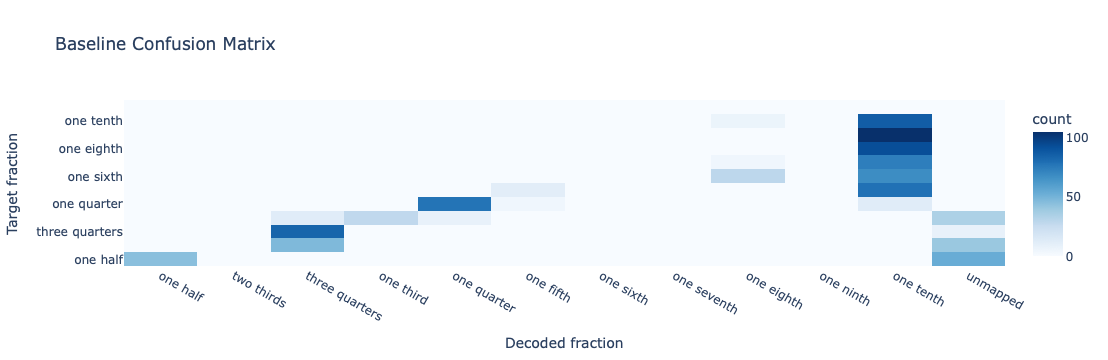

In [7]:
labels_frac = list(FRACTION_MAP.keys())
labels_cm = labels_frac + ["unmapped"]
label_to_idx = {name: i for i, name in enumerate(labels_cm)}

cm = np.zeros((len(labels_cm), len(labels_cm)), dtype=np.int32)
for prompt, decoded in outputs:
    target_label = prompt.frac_1
    decoded_label = fraction_text_to_mathched_text(decoded)
    if decoded_label is None:
        decoded_label = "unmapped"
    cm[label_to_idx[target_label], label_to_idx[decoded_label]] += 1

fig = go.Figure(
    data=go.Heatmap(
        z=cm,
        x=labels_cm,
        y=labels_cm,
        colorscale="Blues",
        colorbar=dict(title="count"),
        hovertemplate="Target: %{y}<br>Decoded: %{x}<br>Count: %{z}<extra></extra>",
    )
)
fig.update_layout(
    title="Baseline Confusion Matrix",
    xaxis_title="Decoded fraction",
    yaxis_title="Target fraction",
    template="plotly_white",
)
fig.show()


## Build Matched Test Set

Patching uses a cleaner subset:
- Keep only records where `decoded_frac == target_frac`.

Reason:
- This reduces donor noise and makes donor labels more trustworthy for intervention targets.

Then split indices and keep a held-out test subset used for donor sampling and patched evaluation.


In [8]:
records = []
with META_PATH.open("r", encoding="utf-8") as handle:
    for line in handle:
        if line.strip():
            records.append(json.loads(line))

records = [rec for rec in records if rec["decoded_frac"] == rec["target_frac"]]
if not records:
    raise ValueError("No matched records found in metadata.jsonl.")

record_idx = np.arange(len(records))
_, test_idx = train_test_split(record_idx, test_size=0.2, random_state=SEED)
test_records = [records[i] for i in test_idx]

print(f"Matched records: {len(records)}")
print(f"Test records: {len(test_records)}")


Matched records: 329
Test records: 66


## Patch with Donor Activations from a Different Random Test Sample

For each source test sample:
1. Sample a **different** donor row from the same test set.
2. Load donor activation tensor from disk.
3. Extract donor vector at donor `%` token index.
4. During generation for the source prompt, replace source hidden state at source `pct_token_index` with donor vector.

This is a single-location, single-layer intervention intended to test whether localized feature replacement can transfer output behavior.


In [9]:
patched_outputs = []

for row_idx, rec in tqdm.contrib.tenumerate(test_records):

    token_ids = rec["token_ids"]
    pct_token_index = rec["pct_token_index"]

    input_ids = torch.tensor([token_ids], dtype=torch.long, device=device)
    attention_mask = torch.ones_like(input_ids)

    other_row_idx = rng.integers(0, len(test_records) - 1)
    if other_row_idx >= row_idx:
        other_row_idx += 1

    donor = test_records[other_row_idx]
    donor_act = np.load(OUT_DIR / f"{donor['seq_id']}.npy")
    donor_vec = torch.tensor(
        donor_act[donor["pct_token_index"]],
        device=device,
        dtype=torch.float32,
    )

    with model.generate(
        input_ids,
        attention_mask=attention_mask,
        max_new_tokens=10,
        pad_token_id=model.tokenizer.eos_token_id,
    ):
        layers[mid_layer].output[0, pct_token_index, :] = donor_vec

        generated = model.generator.output
        if hasattr(generated, "shape"):
            out_token_ids = generated[0].tolist()
            new_ids = out_token_ids[input_ids.shape[1]:]
            decoded = model.tokenizer.decode(new_ids)
        else:
            decoded = str(generated)

        decoded_frac = fraction_text_to_mathched_text(decoded)
        decoded_pct = fraction_text_to_percent(decoded_frac)

        patched_outputs.append(
            {
                "seq_id": rec["seq_id"],
                "pct_token_index": pct_token_index,
                "source_row": row_idx,
                "donor_row": other_row_idx,
                "source_frac": rec["decoded_frac"],
                "source_pct": rec["decoded_pct"],
                "donor_frac": donor["decoded_frac"],
                "donor_pct": donor["decoded_pct"],
                "decoded_sequence": decoded,
                "decoded_frac": decoded_frac,
                "decoded_pct": decoded_pct,
            }
        )


  0%|          | 0/66 [00:00<?, ?it/s]

## Patched Decoding Metric (Donor-Targeted)

This mirrors baseline metrics but changes the target definition:
- baseline target = source percentage/class,
- patched target = donor percentage/class.

Reported metrics:
- `MSE(decoded_pct, donor_pct)` over mapped outputs.
- patched unmapped rate.

Interpretation:
- Improvement here suggests movement toward donor-conditioned behavior after patching.


In [10]:
patched_decoded_pcts = []
patched_target_pcts = []
patched_unmapped = 0

for item in patched_outputs:
    if item["decoded_pct"] is None:
        patched_unmapped += 1
        continue
    patched_decoded_pcts.append(item["decoded_pct"])
    patched_target_pcts.append(item["donor_pct"])

if patched_decoded_pcts:
    diffs = np.array(patched_decoded_pcts, dtype=np.float32) - np.array(
        patched_target_pcts, dtype=np.float32
    )
    patched_mse = float(np.mean(diffs ** 2))
    print(f"Patched MSE (decoded vs donor percent): {patched_mse:.3f}")
    print(f"Patched unmapped rate: {patched_unmapped}/{len(patched_outputs)}")


Patched MSE (decoded vs donor percent): 1099.597
Patched unmapped rate: 4/66


## Patched Confusion Matrix (Donor Fraction as Target)

Class-level post-intervention diagnostic.

Definition:
- Rows: donor fraction class (intervention target).
- Columns: decoded fraction class after patch.

Comparison guidance:
- Compare this matrix to baseline confusion structure.
- Donor-aligned steering should shift mass toward donor class columns for patched samples.


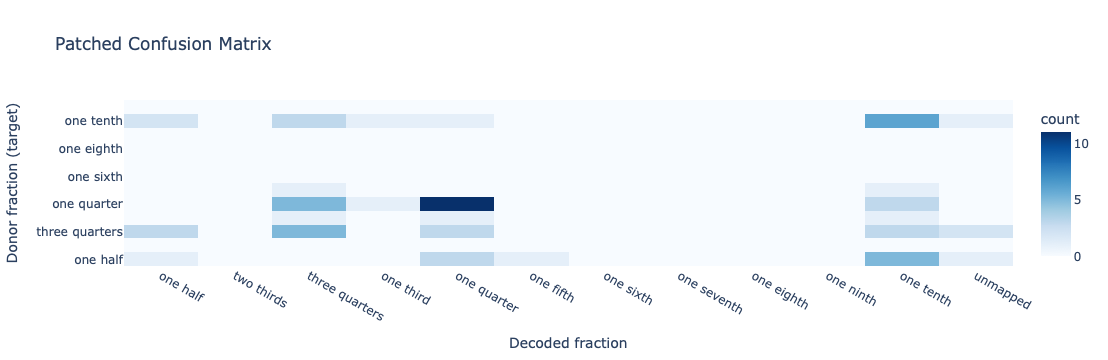

In [11]:
labels_frac = list(FRACTION_MAP.keys())
labels_cm = labels_frac + ["unmapped"]
label_to_idx = {name: i for i, name in enumerate(labels_cm)}

cm_patched = np.zeros((len(labels_cm), len(labels_cm)), dtype=np.int32)
for item in patched_outputs:
    target_label = item["donor_frac"]
    decoded_label = item["decoded_frac"]
    if decoded_label is None:
        decoded_label = "unmapped"
    cm_patched[label_to_idx[target_label], label_to_idx[decoded_label]] += 1

fig = go.Figure(
    data=go.Heatmap(
        z=cm_patched,
        x=labels_cm,
        y=labels_cm,
        colorscale="Blues",
        colorbar=dict(title="count"),
        hovertemplate="Donor target: %{y}<br>Decoded: %{x}<br>Count: %{z}<extra></extra>",
    )
)
fig.update_layout(
    title="Patched Confusion Matrix",
    xaxis_title="Decoded fraction",
    yaxis_title="Donor fraction (target)",
    template="plotly_white",
)
fig.show()
